В этом задании мы реализуем другую модель машинного обучения - линейный классификатор. Линейный классификатор подбирает для каждого класса веса, на которые нужно умножить значение каждого признака и потом сложить вместе. Тот класс, у которого эта сумма больше, и является предсказанием модели.
Задание 1.2 - Линейный классификатор (Linear classifier)

В этом задании вы:

потренируетесь считать градиенты различных многомерных функций
реализуете подсчет градиентов через линейную модель и функцию потерь softmax
реализуете процесс тренировки линейного классификатора
подберете параметры тренировки на практике
На всякий случай, еще раз ссылка на туториал по numpy:
http://cs231n.github.io/python-numpy-tutorial/

In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

%load_ext autoreload
%autoreload 2

from dataset import load_svhn, random_split_train_val
from gradient_check import check_gradient
from metrics import multiclass_accuracy 
import linear_classifer

ModuleNotFoundError: No module named 'dataset'

In [2]:
def prepare_for_linear_classifier(train_X, test_X):
    train_flat = train_X.reshape(train_X.shape[0], -1).astype(float) / 255.0
    test_flat = test_X.reshape(test_X.shape[0], -1).astype(float) / 255.0
    
    # Subtract mean
    mean_image = np.mean(train_flat, axis = 0)
    train_flat -= mean_image
    test_flat -= mean_image
    
    # Add another channel with ones as a bias term
    train_flat_with_ones = np.hstack([train_flat, np.ones((train_X.shape[0], 1))])
    test_flat_with_ones = np.hstack([test_flat, np.ones((test_X.shape[0], 1))])    
    return train_flat_with_ones, test_flat_with_ones
    
train_X, train_y, test_X, test_y = load_svhn("data", max_train=10000, max_test=1000)    
old_shape = train_X.shape
print("old shape ", old_shape)
old_test_X = test_X.copy()
train_X, test_X = prepare_for_linear_classifier(train_X, test_X)
# Split train into train and val
train_X, train_y, val_X, val_y = random_split_train_val(train_X, train_y, num_val = 1000)
print("train_X shape ", train_X.shape)

old shape  (10000, 32, 32, 3)
train_X shape  (9000, 3073)


In [3]:
# TODO: Implement check_gradient function in gradient_check.py
# All the functions below should pass the gradient check

def square(x):
    return float(x*x), 2*x

check_gradient(square, np.array([3.0]))

def array_sum(x):
    assert x.shape == (2,), x.shape
    return np.sum(x), np.ones_like(x)

check_gradient(array_sum, np.array([3.0, 2.0]))

def array_2d_sum(x):
    assert x.shape == (2,2)
    return np.sum(x), np.ones_like(x)

check_gradient(array_2d_sum, np.array([[3.0, 2.0], [1.0, 0.0]]))

CHECK GRADIENT
predictions is 
 [3.]
analytic grad is 
 [6.]
numeric grad array is 
 [6.]
Gradient check passed!
CHECK GRADIENT
predictions is 
 [3. 2.]
analytic grad is 
 [1. 1.]
numeric grad array is 
 [1. 1.]
Gradient check passed!
CHECK GRADIENT
predictions is 
 [[3. 2.]
 [1. 0.]]
analytic grad is 
 [[1. 1.]
 [1. 1.]]
numeric grad array is 
 [[1. 1.]
 [1. 1.]]
Gradient check passed!


True

In [4]:
# TODO Implement softmax and cross-entropy for single sample
probs = linear_classifer.softmax(np.array([-10, 0, 10]))

# Make sure it works for big numbers too!
probs = linear_classifer.softmax(np.array([1000, 0, 0]))
assert np.isclose(probs[0], 1.0)

In [5]:
probs = linear_classifer.softmax(np.array([-5, 0, 5]))
linear_classifer.cross_entropy_loss(probs, np.array([[1]]))

5.006760443547122

In [6]:
# TODO Implement combined function or softmax and cross entropy and produces gradient
loss, grad = linear_classifer.softmax_with_cross_entropy(np.array([1, 0, 0]), np.array([[1]]))
check_gradient(lambda x: linear_classifer.softmax_with_cross_entropy(x, np.array([[1]])), np.array([1, 0, 0], float))

CHECK GRADIENT
predictions is 
 [1. 0. 0.]
analytic grad is 
 [ 0.57611688 -0.78805844  0.21194156]
numeric grad array is 
 [ 0.57611688 -0.78805844  0.21194156]
Gradient check passed!


True

In [7]:
# TODO Extend combined function so it can receive a 2d array with batch of samples
np.random.seed(42)
# Test batch_size = 1
num_classes = 4
batch_size = 1
predictions = np.random.randint(-1, 3, size=(batch_size, num_classes)).astype(float)
target_index = np.random.randint(0, num_classes, size=(batch_size, 1)).astype(int)
check_gradient(lambda x: linear_classifer.softmax_with_cross_entropy(x, target_index), predictions)
print("END")

# Test batch_size = 3
num_classes = 4
batch_size = 3
predictions = np.random.randint(-1, 3, size=(batch_size, num_classes)).astype(float)
target_index = np.random.randint(0, num_classes, size=(batch_size, 1)).astype(int)
# print("target_index is \n", target_index)
for ind in range(target_index.size):
    check_gradient(lambda x: linear_classifer.softmax_with_cross_entropy(x, target_index[ind]), predictions[ind])
print("END")

# Make sure maximum subtraction for numberic stability is done separately for every sample in the batch
probs = linear_classifer.softmax(np.array([[20,0,0], [1000, 0, 0]]))
assert np.all(np.isclose(probs[:, 0], 1.0))
print("END")

CHECK GRADIENT
predictions is 
 [[ 1.  2. -1.  1.]]
analytic grad is 
 [[ 0.20603191  0.56005279 -0.97211661  0.20603191]]
numeric grad array is 
 [[ 0.20603191  0.56005279 -0.97211661  0.20603191]]
Gradient check passed!
END
CHECK GRADIENT
predictions is 
 [ 2. -1. -1.  1.]
analytic grad is 
 [ 0.68145256  0.03392753  0.03392753 -0.74930761]
numeric grad array is 
 [ 0.68145256  0.03392753  0.03392753 -0.74930761]
Gradient check passed!
CHECK GRADIENT
predictions is 
 [0. 1. 1. 1.]
analytic grad is 
 [ 0.10923177  0.29692274  0.29692274 -0.70307726]
numeric grad array is 
 [ 0.10923177  0.29692274  0.29692274 -0.70307726]
Gradient check passed!
CHECK GRADIENT
predictions is 
 [ 1.  2. -1.  2.]
analytic grad is 
 [ 0.15216302  0.41362198 -0.97940697  0.41362198]
numeric grad array is 
 [ 0.15216302  0.41362198 -0.97940697  0.41362198]
Gradient check passed!
END
END


In [33]:
# TODO Implement linear_softmax function that uses softmax with cross-entropy for linear classifier
batch_size = 2
num_classes = 2
num_features = 3
np.random.seed(42)
W = np.random.randint(-1, 3, size=(num_features, num_classes)).astype(float)
X = np.random.randint(-1, 3, size=(batch_size, num_features)).astype(float)
target_index = np.ones(batch_size, dtype=int)

loss, dW = linear_classifer.linear_softmax(X, W, target_index)
check_gradient(lambda w: linear_classifer.linear_softmax(X, w, target_index), W)

CHECK GRADIENT
predictions is 
 [[ 1.  2.]
 [-1.  1.]
 [ 1.  2.]]
analytic grad is 
 [[-0.88079708  0.88079708]
 [-0.8333712   0.8333712 ]
 [ 0.92822295 -0.92822295]]
numeric grad array is 
 [[-0.44039854  0.44039854]
 [-0.4166856   0.4166856 ]
 [ 0.46411148 -0.46411148]]
Gradients are different at (0, 0). Analytic: -0.88080, Numeric: -0.44040


False

In [9]:
# TODO Implement l2_regularization function that implements loss for L2 regularization
linear_classifer.l2_regularization(W, 0.01)
check_gradient(lambda w: linear_classifer.l2_regularization(w, 0.01), W)

CHECK GRADIENT
predictions is 
 [[ 1.  2.]
 [-1.  1.]
 [ 1.  2.]]
analytic grad is 
 [[ 0.02  0.04]
 [-0.02  0.02]
 [ 0.02  0.04]]
numeric grad array is 
 [[ 0.02  0.04]
 [-0.02  0.02]
 [ 0.02  0.04]]
Gradient check passed!


True

**Тренировка!**
Градиенты в порядке, реализуем процесс тренировки!

In [71]:
# TODO: Implement LinearSoftmaxClassifier.fit function
print("train X shape ", train_X.shape)
ind = np.array([1,5,222])
# print(train_X[ind])

classifier = linear_classifer.LinearSoftmaxClassifier()
loss_history = classifier.fit(train_X, train_y, epochs=20, learning_rate=1e-2, batch_size=300, reg=1e-4)

train X shape  (9000, 3073)
num train is  9000
num features is  3073
num classes  is  10
Linear softmax classifier test set accuracy: 18.222222
Epoch 0, loss: 2.297851
Linear softmax classifier test set accuracy: 19.877778
Epoch 1, loss: 2.287501
Linear softmax classifier test set accuracy: 21.122222
Epoch 2, loss: 2.285193
Linear softmax classifier test set accuracy: 21.277778
Epoch 3, loss: 2.267558
Linear softmax classifier test set accuracy: 22.211111
Epoch 4, loss: 2.269622
Linear softmax classifier test set accuracy: 22.133333
Epoch 5, loss: 2.275694
Linear softmax classifier test set accuracy: 22.833333
Epoch 6, loss: 2.265062
Linear softmax classifier test set accuracy: 22.755556
Epoch 7, loss: 2.247698
Linear softmax classifier test set accuracy: 22.777778
Epoch 8, loss: 2.241406
Linear softmax classifier test set accuracy: 23.344444
Epoch 9, loss: 2.238826
Linear softmax classifier test set accuracy: 23.422222
Epoch 10, loss: 2.215847
Linear softmax classifier test set accura

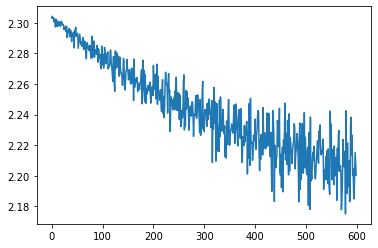

In [72]:
# let's look at the loss history!
plt.plot(loss_history)

test x is  (1000, 3073)
test pred is  [[0.07153769 0.14433985 0.23295234 0.07899388 0.0953093  0.07631218
  0.09404311 0.06282396 0.07656227 0.06712542]
 [0.06006695 0.20750362 0.13284701 0.09230505 0.08892252 0.09776653
  0.07403682 0.08888783 0.08706148 0.07060219]
 [0.07299647 0.14593149 0.10972464 0.10444322 0.0814516  0.1006305
  0.13878714 0.0566983  0.13523704 0.0540996 ]
 [0.05400608 0.18905469 0.2803486  0.08314194 0.07038264 0.05752098
  0.03280941 0.08908653 0.03913233 0.10451681]
 [0.06599753 0.202621   0.21814393 0.13345114 0.06911954 0.08614872
  0.07021061 0.05028095 0.05142013 0.05260645]
 [0.07904968 0.18620537 0.12131012 0.11439114 0.06879154 0.14614142
  0.06682411 0.07854746 0.0805587  0.05818045]
 [0.03011827 0.16352763 0.15583631 0.13612018 0.08341488 0.09691562
  0.06471529 0.12941173 0.06352035 0.07641974]
 [0.05081231 0.23771607 0.19893044 0.09353134 0.12672012 0.06116242
  0.05438349 0.07237263 0.05582935 0.04854183]
 [0.07208463 0.25315377 0.08168937 0.117314

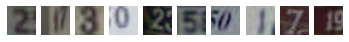

In [66]:
# classifier = linear_classifer.LinearSoftmaxClassifier()
# print("features is ", test_X.shape[1])
# classifier.initW(test_X.shape[0],10)


print("test x is ", test_X.shape)
test_pred = classifier.predict(test_X[:10])
print("test pred is ", test_pred)
label = np.argmax(test_pred, axis=1)
# print("test pred ", test_pred)
print("label is ", label)
# plt.imshow(old_test_X[3].astype(np.uint8))
number = 10
plot_index = 1
for class_index in range(number):
        plt.subplot(1, number, plot_index)
        
        image = old_test_X[class_index]
        plt.imshow(image.astype(np.uint8))
        plt.axis('off')
        plot_index += 1

# plt.show()
test_pred = classifier.predict(test_X)
test_pred = np.argmax(test_pred, axis=1)
print("test pred is \n", test_pred[:10])
print("test_y  is \n", test_y[:10])
test_accuracy = multiclass_accuracy(test_pred, test_y)*100
print('Linear softmax classifier test set accuracy: %f' % (test_accuracy, ))

In [45]:
# a = np.array([[[2,3,2,1], [3,42,4,1], [3,4,2,1]], [[2,3,2,1], [3,0,4,1], [3,4,2,1]], [[2,30,2,1], [3,1,4,1], [3,4,2,1]]])
# print(a)
# print("max is \n", np.max(a, axis=2))
# print(a.ndim)


b = np.array([[2,3,2,1], [3,42,4,1], [3,4,2,1]])
indices = np.array([1,1,2])
print("range is \n",range(len(b)))
output_array = b[range(len(b)) , indices ]
# indices = indices[:, np.newaxis]
print("indices is \n", indices)
print("b is \n",b)
print("definite b is \n", output_array)
# b_max = np.max(b, axis=1)
# b_max = b_max[:, np.newaxis]
# print("b_max is \n", b_max)
# # print("b is \n",b)
# c = b - b_max
# # c = np.subtract(b, c)
# print("c is \n",c)

# sum_exps = np.sum(np.exp(b),  axis=1)
# sum_exps = sum_exps[:, np.newaxis]
# print("sum exps\n",sum_exps)
# probabilities = np.exp(b)/sum_exps
# print("probabilities\n", probabilities)
arr = np.array([[ 2., -1., -1. , 1.], [ 0.,  1. , 1. , 1.] ,[ 1.,  2. ,-1. , 2.]])
arr2 = np.array([[ -2., -1., -1. , 1.], [ 0.,  -1. , 1. , 1.] ,[ 1.,  -2. ,1. , 2.]])
arr3 = np.array([[ 4., -1., 12. , 1.], [ 0.,  -1. , 1. , 1.] ,[ 1.,  -2. ,1. , 2.]])

ls = [arr, arr2, arr3]
sum_arr =np.array(ls)
print("sum arr is\n", sum_arr)
average = np.average(sum_arr, axis=0)
print("average is \n", average)
# part = arr[range(len(arr)), indices]
# print("part  is \n", part)
# print("arr is \n", arr)
# arr[range(len(arr)), indices]-=1
# print("part  is \n", part)
# print("new arr is \n", arr)

# print(b[range(len(b)), indices])
# a = np.array([[1,2,3], [4,5,6], [7,8,9]])
# a = a[np.arange(len(a)), [1,0,2]]
# print("a is \n", a)


range is 
 range(0, 3)
indices is 
 [1 1 2]
b is 
 [[ 2  3  2  1]
 [ 3 42  4  1]
 [ 3  4  2  1]]
definite b is 
 [ 3 42  2]
sum arr is
 [[[ 2. -1. -1.  1.]
  [ 0.  1.  1.  1.]
  [ 1.  2. -1.  2.]]

 [[-2. -1. -1.  1.]
  [ 0. -1.  1.  1.]
  [ 1. -2.  1.  2.]]

 [[ 4. -1. 12.  1.]
  [ 0. -1.  1.  1.]
  [ 1. -2.  1.  2.]]]
average is 
 [[ 1.33333333 -1.          3.33333333  1.        ]
 [ 0.         -0.33333333  1.          1.        ]
 [ 1.         -0.66666667  0.33333333  2.        ]]
